In [34]:
import torch
import torchvision
from PIL import Image

nn = torch.nn
F= torch.nn.functional
TF= torchvision.transforms.functional

In [83]:
class VGGFeatures(nn.Module):
    def __init__(self,layers, pooling="max"):
        super().__init__()

        self.layers = sorted(set(layers))
        self.max_layer = max(self.layers)

        #this is the transform that vgg19 uses ??? why do I need it?
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        self.model = torchvision.models.vgg19(weights="DEFAULT").features[:self.max_layer+1]

        #change padding mode

        if pooling != "max":
            raise Exception("not implemented")

        self.model.eval()
        self.model.requires_grad_(False)

    def forward(self, input, layers = None):
        if layers is None:
            layers = self.layers
        else:
            layers = sorted(set(layers))

        h,w = input.shape[2:4]

        #check min size??!!!

        features = {"input":input}

        input = self.normalize(input)

        for i in range(self.max_layer+1):
            input = self.model[i](input)
            if i in layers:
                features[i] = input
        
        return features

class ScaledMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.register_buffer('eps', torch.tensor(eps))

    def extra_repr(self):
        return f'eps={self.eps:g}'

    def forward(self, input, target):
        diff = input - target
        return diff.pow(2).sum() / diff.abs().sum().add(self.eps)

class ContentLoss(nn.Module):
    def __init__(self, target, eps=1e-8):
        super().__init__()
        self.register_buffer('target', target)
        self.loss = ScaledMSELoss(eps=eps)

    def forward(self, input):
        return self.loss(input, self.target)

class StyleLoss(nn.Module):
    def __init__(self, target, eps=1e-8):
        super().__init__()
        self.register_buffer('target', target)
        self.loss = ScaledMSELoss(eps=eps)

    @staticmethod
    def gram_matrix(target):
        mat = target.flatten(-2)
        # The Gram matrix normalization differs from Gatys et al. (2015) and Johnson et al.
        return mat @ mat.transpose(-2, -1) / mat.shape[-1]

    def forward(self, input):
        return self.loss(self.gram_matrix(input), self.target)

class TVLoss(nn.Module):
    """L2 total variation loss, as in Mahendran et al."""

    def forward(self, input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
        y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
        return (x_diff**2 + y_diff**2).mean()


class SumLoss(nn.ModuleList):
    def __init__(self, losses, verbose=False):
        super().__init__(losses)
        self.verbose = verbose

    def forward(self, *args, **kwargs):
        losses = [loss(*args, **kwargs) for loss in self]
        if self.verbose:
            for i, loss in enumerate(losses):
                print(f'({i}): {loss.item():g}')
        return sum(losses)
        #return sum(loss.to(losses[-1].device) for loss in losses)

class Scale(nn.Module):
    def __init__(self, module, scale):
        super().__init__()
        self.module = module
        self.register_buffer('scale', torch.tensor(scale))

    def extra_repr(self):
        return f'(scale): {self.scale.item():g}'

    def forward(self, *args, **kwargs):
        return self.module(*args, **kwargs) * self.scale

class LayerApply(nn.Module):
    def __init__(self, module, layer):
        super().__init__()
        self.module = module
        self.layer = layer

    def extra_repr(self):
        return f'(layer): {self.layer!r}'

    def forward(self, input):
        return self.module(input[self.layer])

def gen_scales(start, end):
    scale = end
    i = 0
    scales = set()
    while scale >= start:
        scales.add(scale)
        i += 1
        scale = round(end / pow(2, i/2))
    return sorted(scales)

def size_to_fit(size, max_dim, scale_up=False):
    w, h = size
    if not scale_up and max(h, w) <= max_dim:
        return w, h
    new_w, new_h = max_dim, max_dim
    if h > w:
        new_w = round(max_dim * w / h)
    else:
        new_h = round(max_dim * h / w)
    return new_w, new_h

class EMA(nn.Module):
    """A bias-corrected exponential moving average, as in Kingma et al. (Adam)."""

    def __init__(self, input, decay):
        super().__init__()
        self.register_buffer('value', torch.zeros_like(input))
        self.register_buffer('decay', torch.tensor(decay))
        self.register_buffer('accum', torch.tensor(1.))
        self.update(input)

    def get(self):
        return self.value / (1 - self.accum)

    def update(self, input):
        self.accum *= self.decay
        self.value *= self.decay
        self.value += (1 - self.decay) * input


In [84]:
class StyleTransfer:
    def __init__(self, pooling="max"):
        self.image = None
        self.average = None

        self.content_layers = [22]
        self.style_layers = [1, 6, 11, 20, 29]

        style_weights = [256,64,16,4,1]
        weight_sum = sum(style_weights)
        self.style_layer_weights = [w/weight_sum for w in style_weights]

        self.model = VGGFeatures(self.style_layers + self.content_layers, pooling=pooling).to("cuda")

    def stylize(self, content_image, style_images, *,
        style_weights=None,
        content_weight: float = 0.015,
        tv_weight: float = 2.,
        min_scale: int = 128,
        end_scale: int = 512,
        iterations: int = 500,
        initial_iterations: int = 1000,
        step_size: float = 0.02,
        avg_decay: float = 0.99,
        init: str = 'content',
        style_scale_fac: float = 1.,
        style_size: int = None,
        callback=None):

        content_weights = [content_weight / len(self.content_layers)] * len(self.content_layers)
        
        #note, this is the weigth of the style images if there are more than one, 
        # different the the weight of the style layers
        if style_weights is None:
            style_weights = [1 / len(style_images)] * len(style_images)
        else:
            weight_sum = sum(abs(w) for w in style_weights)
            style_weights = [weight / weight_sum for weight in style_weights]

        tv_loss = Scale(LayerApply(TVLoss(),"input"),tv_weight)

        scales = gen_scales(min_scale, end_scale)

        cw, ch = size_to_fit(content_image.size, scales[0], scale_up=True)
        if init == 'content':
            self.image = TF.to_tensor(content_image.resize((cw,ch), Image.Resampling.LANCZOS)).unsqueeze(0)
        else:
            raise Exception(f'Unknown init: {init}')

        self.image = self.image.to("cuda")

        #opt = None

        for scale in scales:
            torch.cuda.empty_cache()

            cw, ch = size_to_fit(content_image.size, scale, scale_up=True)
            content = TF.to_tensor(content_image.resize((cw,ch), Image.Resampling.LANCZOS)).unsqueeze(0).to("cuda")

            #why do we need to interpolate the content image?
            self.image = F.interpolate(self.image.detach(), size=(ch,cw), mode='bicubic').clamp(0,1)

            self.average = EMA(self.image, avg_decay)

            self.image.requires_grad_()

            print(f"processing content image {cw}x{ch}")
            content_feats = self.model(content, layers=self.content_layers)
            content_losses = []
            for layer, weight in zip(self.content_layers, content_weights):
                content_losses.append(Scale(LayerApply(ContentLoss(content_feats[layer]), layer) , weight))

            style_targets = {}
            style_losses = []

            for i, image in enumerate(style_images):
                if style_size is None:
                    sw, sh = size_to_fit(image.size, round(scale*style_scale_fac))
                else:
                    sw, sh = size_to_fit(image.size, style_size)
                style = TF.to_tensor(image.resize((sw,sh), Image.Resampling.LANCZOS)).unsqueeze(0).to("cuda")
                print(f"processing style image {i} {sw}x{sh}")
                style_feats = self.model(style, layers=self.style_layers)
                for layer in self.style_layers:
                    target = StyleLoss.gram_matrix(style_feats[layer])*style_weights[i]
                    #what, are we just taking weighted average for the different style images?
                    #don't want to compute the loss seprately for each style image?
                    if layer not in style_targets:
                        style_targets[layer] = target
                    else:
                        style_targets[layer] += target

            for layer, weight in zip(self.style_layers, self.style_layer_weights):
                style_losses.append(Scale(LayerApply(StyleLoss(style_targets[layer]), layer) , weight))

            crit = SumLoss([*content_losses, *style_losses, tv_loss])

            opt = torch.optim.Adam([self.image], lr=step_size)

            torch.cuda.empty_cache()

            actual_its = initial_iterations if scale == scales[0] else iterations

            for i in range(1, actual_its+1):
                feats = self.model(self.image)
                loss = crit(feats)
                opt.zero_grad()
                loss.backward()
                opt.step()

                with torch.no_grad():
                    self.image.clamp(0,1)
                self.average.update(self.image)

                with torch.no_grad():
                    self.image.copy_(self.average.get())

        return self.get_image()

    def get_image_tensor(self):
        return self.average.get().detach()[0].clamp(0, 1)

    def get_image(self, image_type='pil'):
        if self.average is not None:
            image = self.get_image_tensor()
            if image_type.lower() == 'pil':
                return TF.to_pil_image(image)
            elif image_type.lower() == 'np_uint16':
                arr = image.cpu().movedim(0, 2).numpy()
                return np.uint16(np.round(arr * 65535))
            else:
                raise ValueError("image_type must be 'pil' or 'np_uint16'")

In [64]:
cim = Image.open("images/input.jpg")
sim = Image.open("images/style.jpg")

processing content image 128x72
processing style image 0 128x75
processing content image 181x102
processing style image 0 181x106
processing content image 256x144
processing style image 0 256x150
processing content image 362x204
processing style image 0 362x212
processing content image 512x288
processing style image 0 512x300


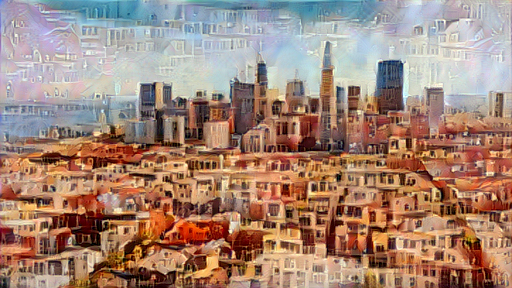

In [85]:
ST = StyleTransfer()
ST.stylize(cim, [sim], init='content')

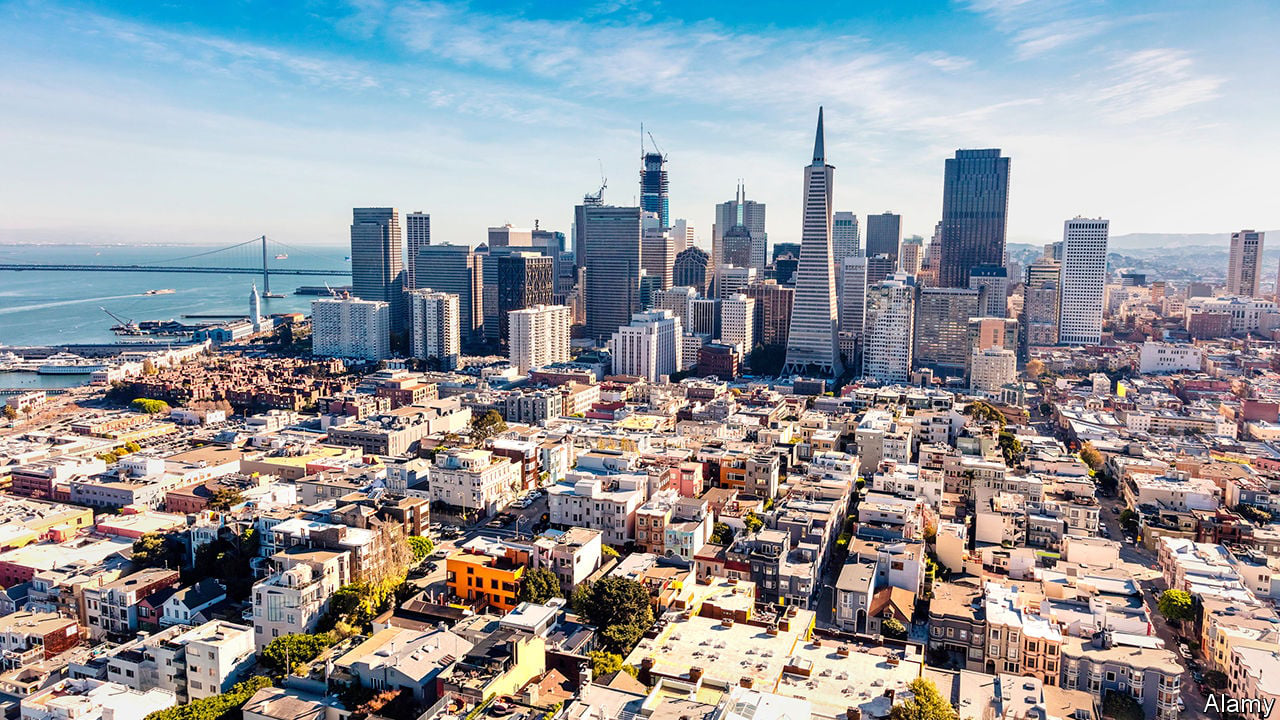

In [86]:
cim

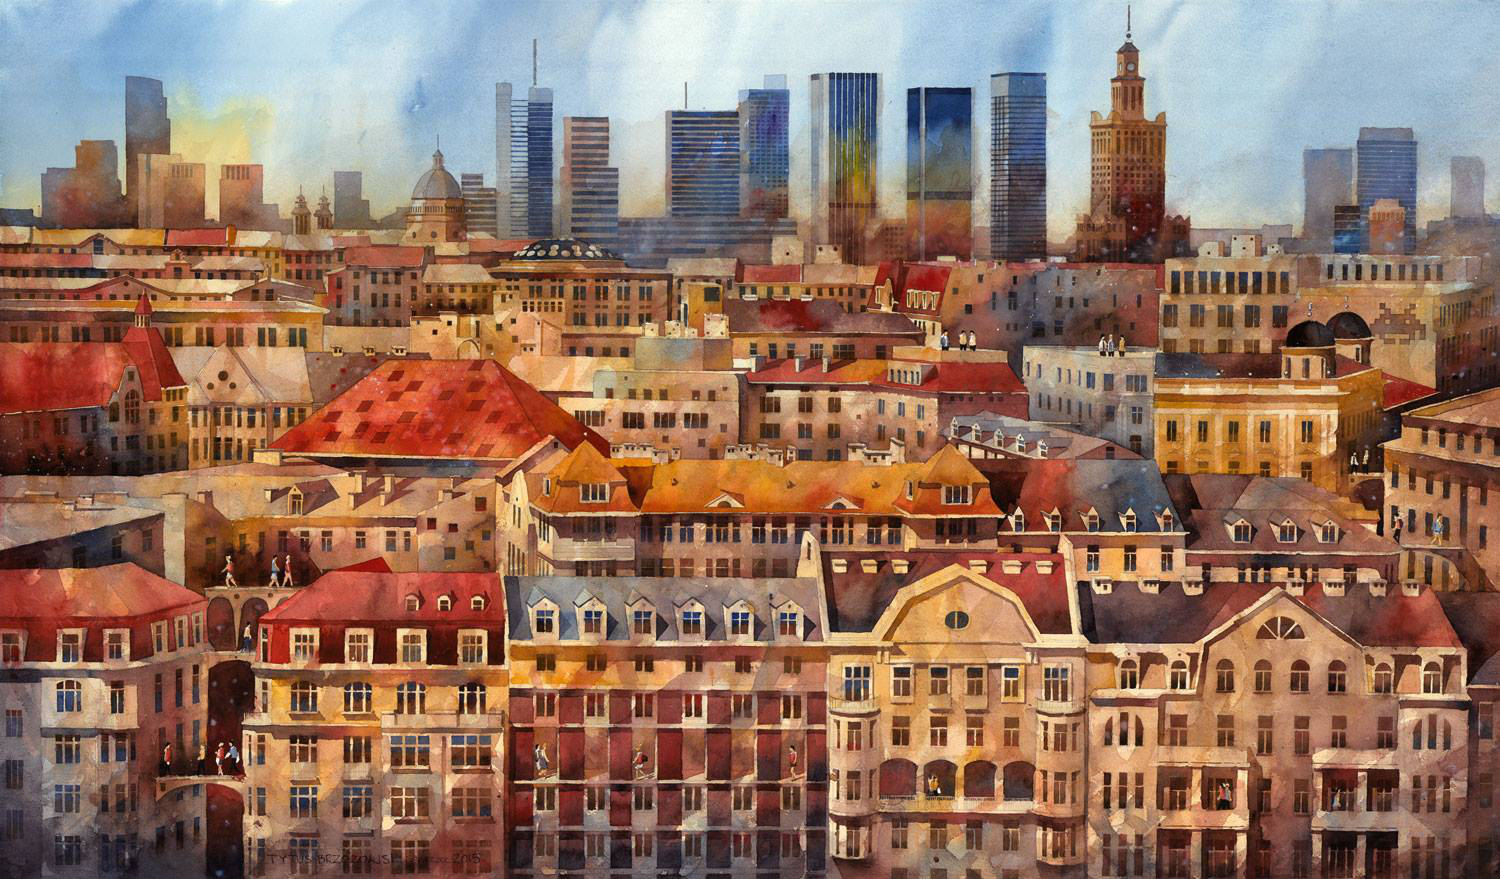

In [88]:
sim

In [49]:
a.shape

torch.Size([3, 256, 256])

In [50]:
a.unsqueeze(0)

tensor([[[[0.1608, 0.2157, 0.2745,  ..., 0.5216, 0.5137, 0.5059],
          [0.2667, 0.3059, 0.3412,  ..., 0.5412, 0.5137, 0.5137],
          [0.3216, 0.3569, 0.3804,  ..., 0.5608, 0.5216, 0.5255],
          ...,
          [0.5922, 0.1843, 0.0627,  ..., 0.6078, 0.7686, 0.9765],
          [0.5490, 0.0824, 0.0157,  ..., 0.5216, 0.8627, 0.9451],
          [0.5961, 0.2118, 0.0118,  ..., 0.6549, 0.9529, 0.9176]],

         [[0.6471, 0.6549, 0.6588,  ..., 0.7255, 0.7216, 0.7176],
          [0.6627, 0.6667, 0.6706,  ..., 0.7294, 0.7255, 0.7255],
          [0.6784, 0.6863, 0.6863,  ..., 0.7373, 0.7373, 0.7333],
          ...,
          [0.5647, 0.1804, 0.0667,  ..., 0.5725, 0.6078, 0.7373],
          [0.5098, 0.0980, 0.0392,  ..., 0.4941, 0.6667, 0.7216],
          [0.5451, 0.2196, 0.0157,  ..., 0.5216, 0.7412, 0.6980]],

         [[0.8510, 0.8627, 0.8745,  ..., 0.8706, 0.8627, 0.8588],
          [0.8706, 0.8784, 0.8784,  ..., 0.8745, 0.8588, 0.8588],
          [0.8824, 0.8902, 0.8863,  ..., 0

In [30]:
gen_scales(128,1500)

[133, 188, 265, 375, 530, 750, 1061, 1500]

In [13]:
q = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])

In [26]:
F.pad(q, (0,0,3,1))

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.],
        [0., 0., 0.]])

In [22]:
q

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])